Generation 1, Best Fitness: 3931.2815048817833
Generation 2, Best Fitness: 3923.5536016822275
Generation 3, Best Fitness: 3770.6072545239967
Generation 4, Best Fitness: 3624.3199292452186
Generation 5, Best Fitness: 3730.7018118976785
Generation 6, Best Fitness: 3705.576289105108
Generation 7, Best Fitness: 3584.2302756778463
Generation 8, Best Fitness: 3466.709646327875
Generation 9, Best Fitness: 3428.8709127783964
Generation 10, Best Fitness: 3327.28444049656
Generation 11, Best Fitness: 3372.252219595072
Generation 12, Best Fitness: 3389.762949155867
Generation 13, Best Fitness: 3372.252219595072
Generation 14, Best Fitness: 3296.7083891403095
Generation 15, Best Fitness: 3293.0796615903664
Generation 16, Best Fitness: 3213.899307192918
Generation 17, Best Fitness: 3176.6885292143097
Generation 18, Best Fitness: 3130.0486086415503
Generation 19, Best Fitness: 3132.1500356485058
Generation 20, Best Fitness: 3106.9556287744917
Generation 21, Best Fitness: 3106.9556287744917
Generatio

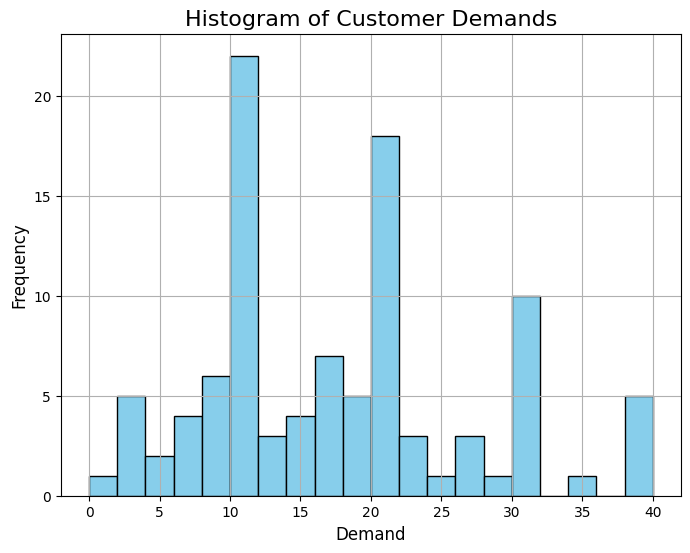

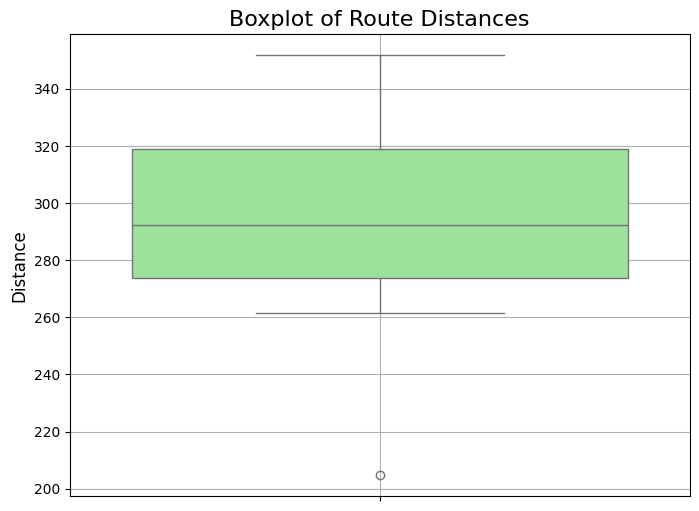

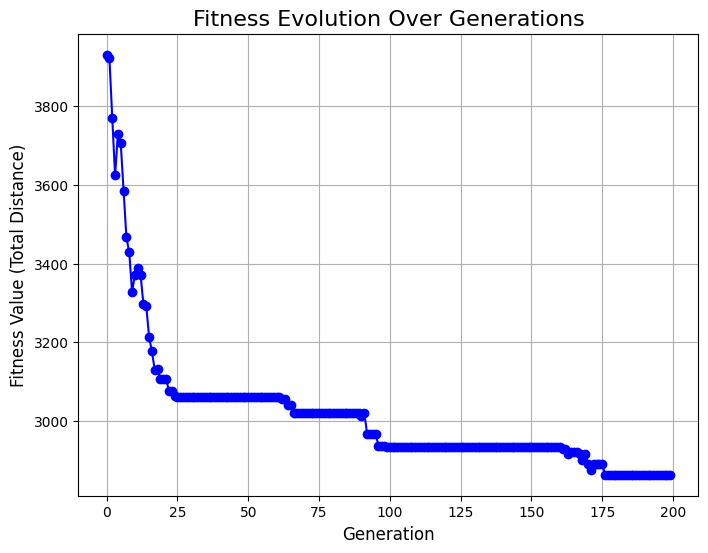

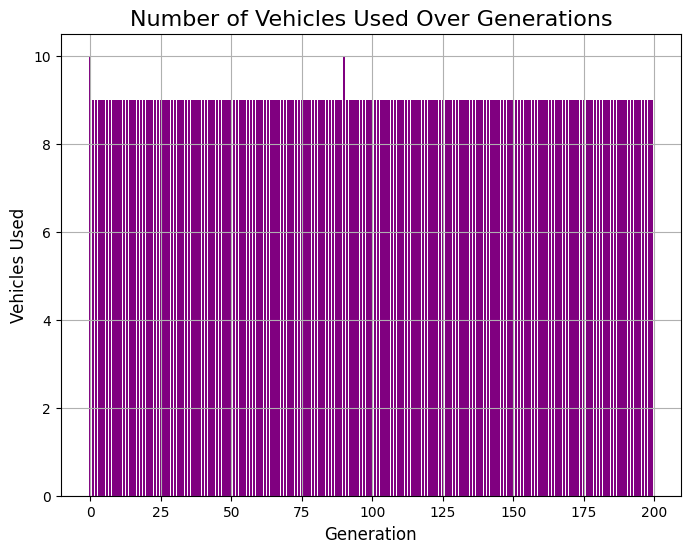

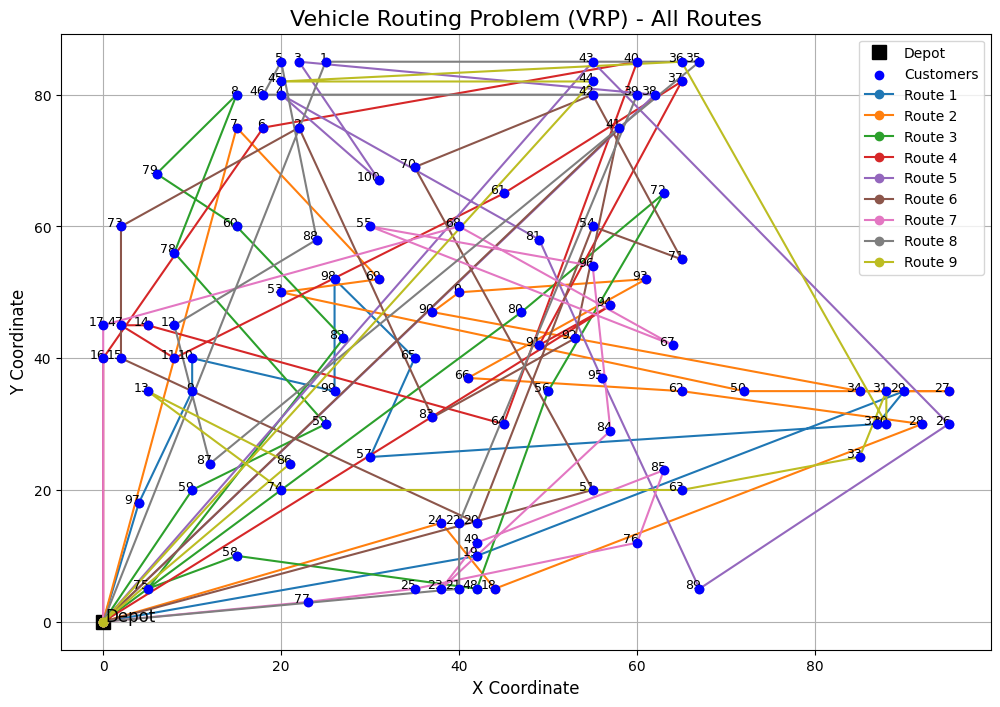

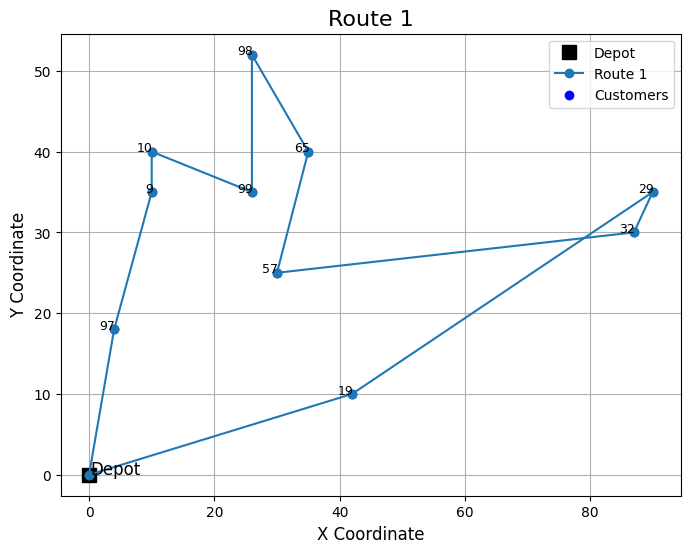

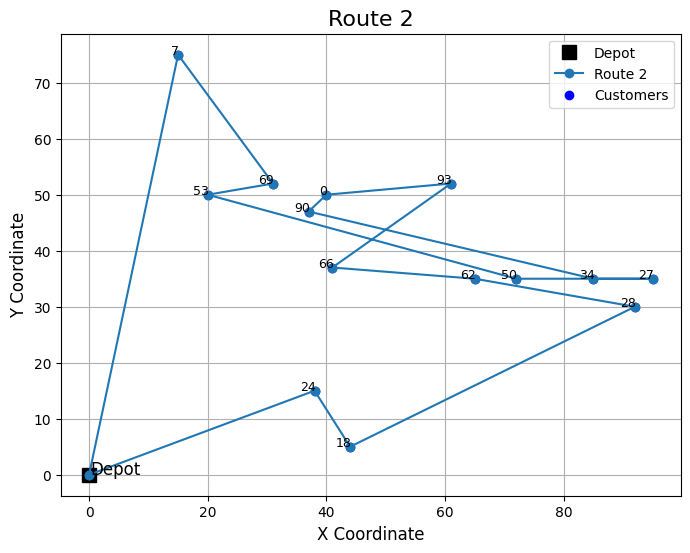

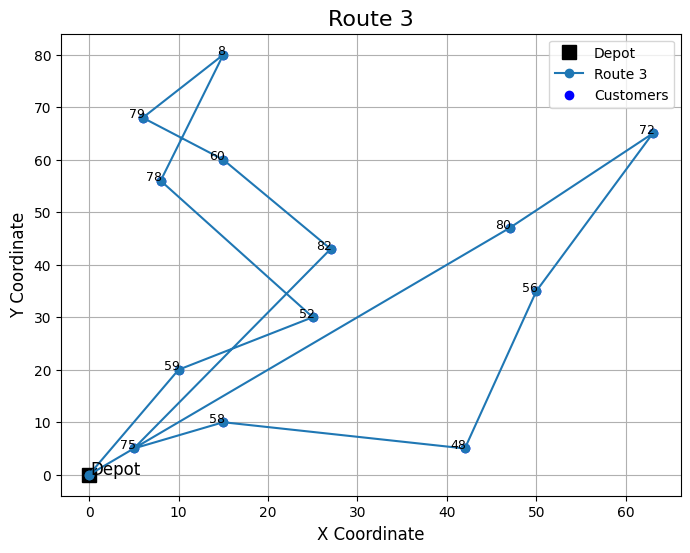

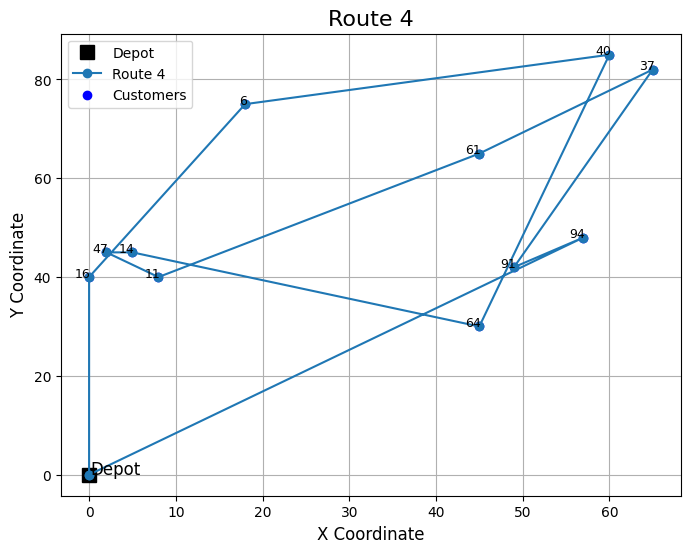

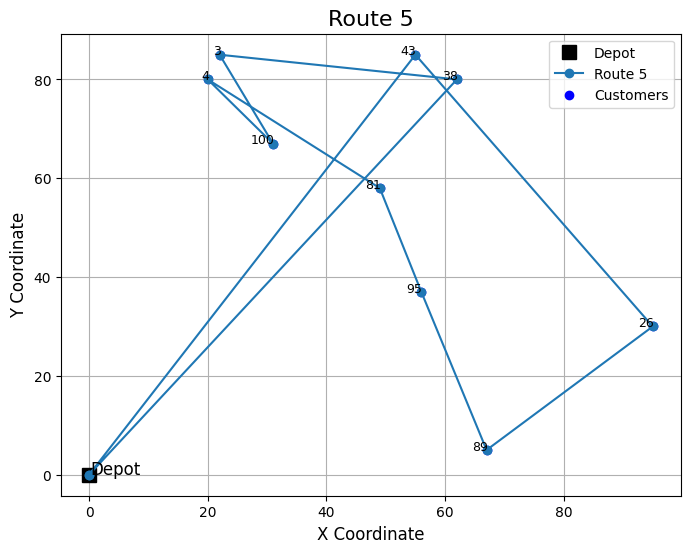

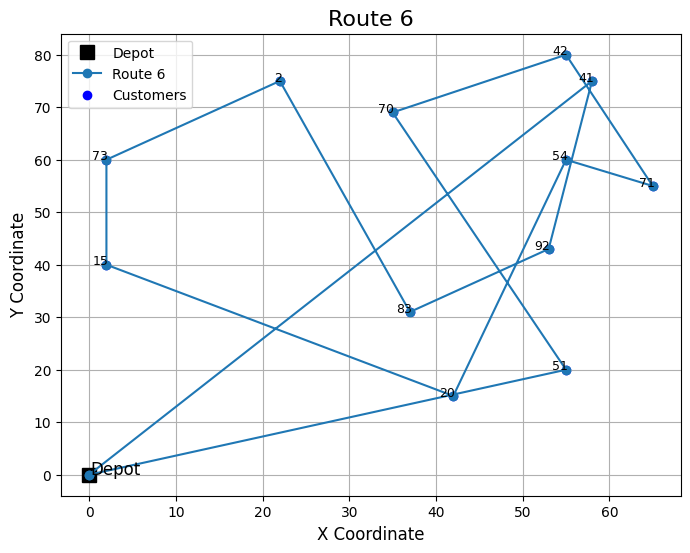

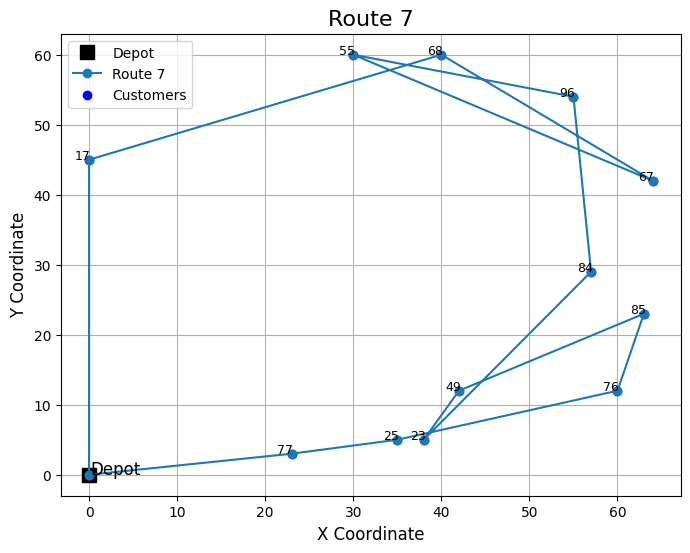

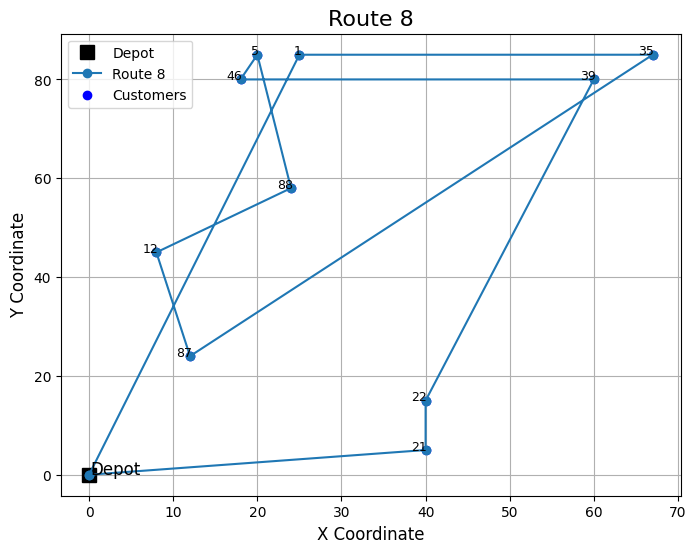

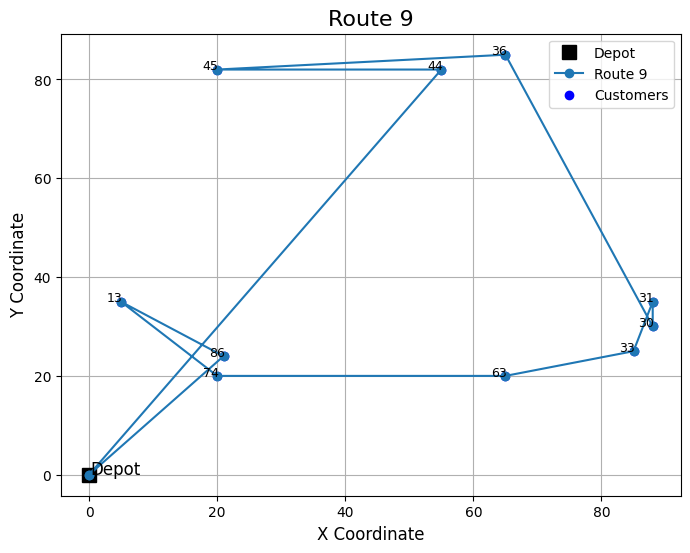

Testing: Population=20, Generations=50, Mutation Rate=0.01
Testing: Population=20, Generations=50, Mutation Rate=0.05
Testing: Population=20, Generations=50, Mutation Rate=0.1
Testing: Population=20, Generations=100, Mutation Rate=0.01
Testing: Population=20, Generations=100, Mutation Rate=0.05
Testing: Population=20, Generations=100, Mutation Rate=0.1
Testing: Population=20, Generations=200, Mutation Rate=0.01
Testing: Population=20, Generations=200, Mutation Rate=0.05
Testing: Population=20, Generations=200, Mutation Rate=0.1
Testing: Population=50, Generations=50, Mutation Rate=0.01
Testing: Population=50, Generations=50, Mutation Rate=0.05
Testing: Population=50, Generations=50, Mutation Rate=0.1
Testing: Population=50, Generations=100, Mutation Rate=0.01
Testing: Population=50, Generations=100, Mutation Rate=0.05
Testing: Population=50, Generations=100, Mutation Rate=0.1
Testing: Population=50, Generations=200, Mutation Rate=0.01
Testing: Population=50, Generations=200, Mutation R

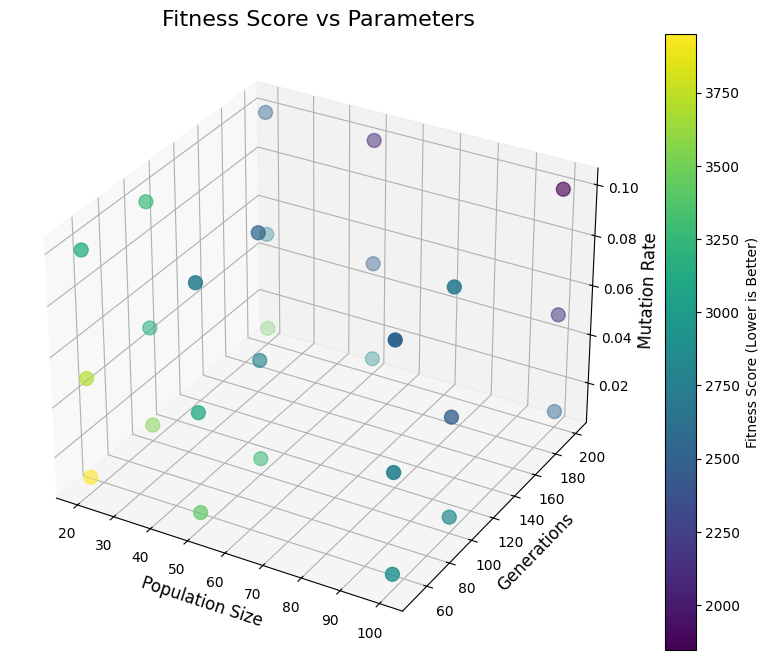

In [23]:
import tkinter as tk
from tkinter import filedialog
import random
import math
import numpy as np
import matplotlib.pyplot as plt


# Function to parse the input file and extract vehicle capacity and customer data
def parse_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    vehicle_capacity = None
    customers = []

    # Extract vehicle capacity by looking for the "CAPACITY" line
    for i, line in enumerate(lines):
        if "CAPACITY" in line:
            # Get the next line for the actual values
            values_line = lines[i + 1].strip().split()
            vehicle_capacity = int(values_line[1])  # Extract the capacity value
            break

    if vehicle_capacity is None:
        raise ValueError("Vehicle capacity not found in the input file.")

    # Locate the start of the customer data
    start_index = None
    for i, line in enumerate(lines):
        if "CUST NO." in line:
            start_index = i + 1  # Data starts immediately after this line
            break

    if start_index is None:
        raise ValueError("Customer data section not found in file.")

    # Parse customer data
    for line in lines[start_index:]:
        data = line.strip().split()
        if len(data) < 7:  # Ignore lines without sufficient data
            continue
        try:
            customer = {
                "id": int(data[0]),
                "x": float(data[1]),
                "y": float(data[2]),
                "demand": int(data[3]),
                "ready_time": int(data[4]),
                "due_date": int(data[5]),
                "service_time": int(data[6])
            }
            customers.append(customer)
        except ValueError:
            # Skip malformed lines
            continue

    return vehicle_capacity, customers


# Function to calculate Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    return math.sqrt((cust1['x'] - cust2['x'])**2 + (cust1['y'] - cust2['y'])**2)


# Function to calculate travel time (using Euclidean distance as a proxy for time)
def calculate_travel_time(cust1, cust2):
    return euclidean_distance(cust1, cust2)


# Genetic Algorithm helpers
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population


def fitness(individual, dist_matrix, vehicle_capacity, customers):
    total_distance = 0
    total_demand = 0
    num_vehicles = 1  # Start with one vehicle

    for i in range(len(individual) - 1):
        current_customer = customers[individual[i]]
        next_customer = customers[individual[i + 1]]

        total_distance += dist_matrix[individual[i]][individual[i + 1]]
        total_demand += current_customer['demand']

        # Check if we exceed the vehicle's capacity
        if total_demand > vehicle_capacity:
            num_vehicles += 1
            total_demand = next_customer['demand']  # Start with the next customer's demand

    return total_distance  # You can modify to add penalty based on vehicles used


def crossover(parent1, parent2):
    # Perform crossover between two parents (partially mapped crossover)
    size = len(parent1)
    child = [-1] * size
    crossover_point = random.randint(0, size)

    # Copy part of the first parent to the child
    for i in range(crossover_point):
        child[i] = parent1[i]

    # Fill the remaining part with genes from the second parent
    for i in range(size):
        if child[i] == -1:
            for gene in parent2:
                if gene not in child:
                    child[i] = gene
                    break
    return child


def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        # Randomly choose two positions to swap
        pos1, pos2 = random.sample(range(len(individual)), 2)
        individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual


def select_parents(population, dist_matrix, vehicle_capacity, customers):
    # Tournament selection: select the best two individuals
    tournament_size = 5
    selected = random.sample(population, tournament_size)
    selected.sort(key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    return selected[0], selected[1]


# Plotting functions
def plot_routes(customers, routes, depot=(0, 0)):
    plt.figure(figsize=(12, 8))
    plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
    plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

    customer_x = [cust['x'] for cust in customers]
    customer_y = [cust['y'] for cust in customers]
    plt.scatter(customer_x, customer_y, c='b', label="Customers", zorder=5)

    for cust in customers:
        plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

    for route_idx, route in enumerate(routes):
        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")

    plt.title('Vehicle Routing Problem (VRP) - All Routes', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_individual_routes(customers, routes, depot=(0, 0)):
    for route_idx, route in enumerate(routes):
        plt.figure(figsize=(8, 6))
        plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
        plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")
        plt.scatter([customers[customer_id]['x'] for customer_id in route],
                    [customers[customer_id]['y'] for customer_id in route],
                    c='b', label="Customers")

        for customer_id in route:
            cust = customers[customer_id]
            plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

        plt.title(f'Route {route_idx + 1}', fontsize=16)
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()


# Extract routes
def extract_routes(best_individual, customers, vehicle_capacity):
    routes = []
    total_demand = 0
    routes.append([best_individual[0]])

    for i in range(1, len(best_individual)):
        current_customer = customers[best_individual[i - 1]]
        next_customer = customers[best_individual[i]]
        total_demand += current_customer['demand']

        if total_demand > vehicle_capacity:
            routes.append([best_individual[i]])
            total_demand = next_customer['demand']
        else:
            routes[-1].append(best_individual[i])

    return routes



import seaborn as sns

# Function to plot fitness evolution over generations
def plot_fitness_evolution(fitness_values):
    plt.figure(figsize=(8, 6))
    plt.plot(fitness_values, color='b', marker='o')
    plt.title('Fitness Evolution Over Generations', fontsize=16)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Value (Total Distance)', fontsize=12)
    plt.grid(True)
    plt.show()

# Function to plot bar plot of the number of vehicles used in each generation
def plot_vehicles_used(evolved_vehicles_count):
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(evolved_vehicles_count)), evolved_vehicles_count, color='purple')
    plt.title('Number of Vehicles Used Over Generations', fontsize=16)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Vehicles Used', fontsize=12)
    plt.grid(True)
    plt.show()

# Add code to track fitness and vehicles used during the genetic algorithm
def solve_vrptw_with_statistics(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 200
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)
    
    fitness_history = []  # Track fitness over generations
    evolved_vehicles_count = []  # Track vehicles used over generations

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        # Track the fitness and vehicles used in the generation
        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        num_vehicles = len(routes)
        evolved_vehicles_count.append(num_vehicles)

        print(f"Generation {gen + 1}, Best Fitness: {fitness_history[-1]}")

    # Final best individual and routes
    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)
    print("\nOptimized Routes:")
    for i, route in enumerate(routes):
        print(f"Vehicle {i + 1}: {route}")

    # Descriptive Statistical Plots
    plot_customer_demands(customers)  # Histogram of customer demands
    plot_route_distances(routes, dist_matrix, customers)  # Boxplot of route distances
    plot_fitness_evolution(fitness_history)  # Fitness evolution over generations
    plot_vehicles_used(evolved_vehicles_count)  # Number of vehicles used per generation

    plot_routes(customers, routes, depot=(0, 0))
    plot_individual_routes(customers, routes, depot=(0, 0))
    

# def evaluate_parameter_combinations(file_path):
#     # Load problem data
#     vehicle_capacity, customers = parse_input(file_path)
#     num_customers = len(customers)

#     # Create distance matrix
#     dist_matrix = np.zeros((num_customers, num_customers))
#     for i in range(num_customers):
#         for j in range(num_customers):
#             dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

#     # Parameter grids
#     population_sizes = [30, 50, 100]  # Example population sizes
#     generations_list = [50, 100, 200]  # Example number of generations
#     mutation_rates = [0.01, 0.05, 0.1]  # Example mutation rates

#     # Store results
#     results = []

#     # Evaluate each combination
#     for population_size in population_sizes:
#         for generations in generations_list:
#             for mutation_rate in mutation_rates:
#                 print(f"Evaluating: PopSize={population_size}, Generations={generations}, MutRate={mutation_rate}")

#                 # Initialize population
#                 population = generate_initial_population(population_size, num_customers)

#                 # Run genetic algorithm
#                 best_fitness = float('inf')  # Track the best fitness score
#                 for gen in range(generations):
#                     new_population = []
#                     for _ in range(population_size // 2):
#                         parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
#                         child1 = crossover(parent1, parent2)
#                         child2 = crossover(parent2, parent1)
#                         new_population.append(mutate(child1, mutation_rate))
#                         new_population.append(mutate(child2, mutation_rate))
#                     population = new_population

#                     # Evaluate best individual in the generation
#                     current_best = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
#                     best_fitness = min(best_fitness, fitness(current_best, dist_matrix, vehicle_capacity, customers))

#                 # Save the result
#                 results.append({
#                     "Population Size": population_size,
#                     "Generations": generations,
#                     "Mutation Rate": mutation_rate,
#                     "Best Fitness": best_fitness
#                 })

#     # Display results in tabular format
#     print("\nFitness Score Comparison:")
#     print(f"{'Population':<12}{'Generations':<12}{'Mutation Rate':<15}{'Best Fitness':<15}")
#     for result in results:
#         print(f"{result['Population Size']:<12}{result['Generations']:<12}{result['Mutation Rate']:<15}{result['Best Fitness']:<15.2f}")

#     # Plot fitness score comparison
#     plot_fitness_comparison(results)


# # Function to Plot Fitness Score Comparison
# def plot_fitness_comparison(results):
#     # Convert results into a structured grid for visualization
#     population_sizes = sorted(set(res["Population Size"] for res in results))
#     generations_list = sorted(set(res["Generations"] for res in results))
#     mutation_rates = sorted(set(res["Mutation Rate"] for res in results))

#     fig, axs = plt.subplots(len(population_sizes), len(generations_list), figsize=(15, 10), sharey=True)

#     for i, pop_size in enumerate(population_sizes):
#         for j, generations in enumerate(generations_list):
#             ax = axs[i, j]
#             scores = [res["Best Fitness"] for res in results
#                       if res["Population Size"] == pop_size and res["Generations"] == generations]
#             ax.bar([f"{mr:.2f}" for mr in mutation_rates], scores, color='skyblue', edgecolor='black')
#             ax.set_title(f"Pop={pop_size}, Gen={generations}", fontsize=10)
#             ax.set_xlabel("Mutation Rate")
#             ax.set_ylabel("Fitness" if j == 0 else "")

#     fig.suptitle("Fitness Score Comparison Across Parameters", fontsize=16)
#     plt.tight_layout()
#     plt.show()

def evaluate_parameter_combinations(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Precompute distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter ranges
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    # To store results
    results = []
    best_fitness = float('inf')
    best_parameters = None

    # Grid search over all parameter combinations
    for pop_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                print(f"Testing: Population={pop_size}, Generations={generations}, Mutation Rate={mutation_rate}")
                population = generate_initial_population(pop_size, num_customers)
                fitness_history = []

                for gen in range(generations):
                    new_population = []
                    for _ in range(pop_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                    fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))

                # Record results for this parameter combination
                final_fitness = fitness_history[-1]
                results.append((pop_size, generations, mutation_rate, final_fitness))

                # Update the best fitness and parameters
                if final_fitness < best_fitness:
                    best_fitness = final_fitness
                    best_parameters = (pop_size, generations, mutation_rate)

    # Print best parameters
    print("\nBest Parameters:")
    print(f"Population Size: {best_parameters[0]}, Generations: {best_parameters[1]}, Mutation Rate: {best_parameters[2]}")
    print(f"Best Fitness Score: {best_fitness}")

    # Visualize Results
    plot_fitness_comparison(results)


def plot_fitness_comparison(results):
    """
    Plots a 3D surface or scatter plot to compare fitness scores across parameter combinations.
    """
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    # Extract data
    pop_sizes, generations, mutation_rates, fitness_scores = zip(*results)

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(pop_sizes, generations, mutation_rates, c=fitness_scores, cmap=cm.viridis, s=100)
    plt.colorbar(sc, label="Fitness Score (Lower is Better)")

    ax.set_title("Fitness Score vs Parameters", fontsize=16)
    ax.set_xlabel("Population Size", fontsize=12)
    ax.set_ylabel("Generations", fontsize=12)
    ax.set_zlabel("Mutation Rate", fontsize=12)

    plt.show()



# Main entry point for file selection and solving
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = "rc1/rc101.txt"
    if file_path:
        solve_vrptw_with_statistics(file_path)
        evaluate_parameter_combinations(file_path)

        
        